# AWD-LSTM (no pretraining)

In this notebook we train an AWD-LSTM model for the proxy task without any language model pretraining.  This notebook has been adapted from the fast.ai [ULMFit tutorial](https://github.com/fastai/course-nlp/blob/master/nn-vietnamese.ipynb).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.text import *
import glob
import eval_models

In [2]:
bs=48

In [3]:
torch.cuda.set_device(0)

In [4]:
data_path = Config.data_path()

In [5]:
name = 'bscore_lm'
path = data_path/name
path.mkdir(exist_ok=True, parents=True)

### Train Classifier

In [6]:
train_df = pd.read_csv(path/'train64.csv')
valid_df = pd.read_csv(path/'valid64.csv')
test_df = pd.read_csv(path/'test64.csv')

In [7]:
basicTokenizer = Tokenizer(pre_rules=[], post_rules=[])
data_clas = TextDataBunch.from_df(path, train_df, valid_df, tokenizer=basicTokenizer, bs=bs, num_workers=1)

In [20]:
len(data_clas.vocab.itos)

38544

In [8]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, pretrained=False, drop_mult=0.5, 
                                  metrics=[accuracy, FBeta(average='macro', beta=1)])

In [9]:
learn_c.lr_find()

epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


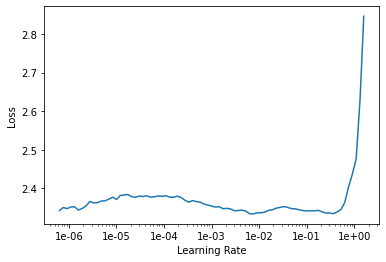

In [10]:
learn_c.recorder.plot()

In [11]:
lr = 3e-4

In [12]:
learn_c.fit_one_cycle(1, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.462111,2.125985,0.266204,0.231142,01:06


In [13]:
learn_c.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.003999,2.286129,0.278148,0.233050,01:07
1,0.665091,2.292577,0.280741,0.247882,01:08


In [14]:
learn_c.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.608233,2.592708,0.284537,0.243926,01:08
1,0.406934,2.521525,0.301574,0.270409,01:08


In [15]:
mdl_path = path/'models'
mdl_path.mkdir(exist_ok=True, parents=True)

In [16]:
learn_c.save(mdl_path/'awdlstm_clas-verify')

In [10]:
learn_c = learn_c.load(mdl_path/'awdlstm_clas')

### Evaluate Classifier

Evaluate on the proxy task -- classifying fixed-length chunks of bootleg score features.

In [17]:
data_clas_test = TextDataBunch.from_df(path, train_df, test_df, tokenizer=basicTokenizer, bs=bs, num_workers=1)

In [18]:
learn_c.validate(data_clas_test.valid_dl)

[2.369825, tensor(0.3205), tensor(0.2965)]

Evaluate on the original task -- classifying pages of sheet music.  We can evaluate our models in two ways:
- applying the model to a variable length sequence
- applying the model to multiple fixed-length windows and averaging the predictions

First we evaluate the model on variable length inputs.  Report results with and without applying priors.

In [19]:
train_fullpage_df = pd.read_csv(path/'train.fullpage.csv')
valid_fullpage_df = pd.read_csv(path/'valid.fullpage.csv')
test_fullpage_df = pd.read_csv(path/'test.fullpage.csv')

In [20]:
(acc, acc_with_prior), (f1, f1_with_prior) = eval_models.calcAccuracy_fullpage(learn_c, path, train_fullpage_df, valid_fullpage_df, test_fullpage_df)
(acc, acc_with_prior), (f1, f1_with_prior)

((0.4440183937549591, 0.4202454090118408),
 (0.31592778321459924, 0.2542476615309367))

Now we evaluate the model by considering multiple fixed-length windows and averaging the predictions.

In [21]:
test_ensemble_df = pd.read_csv(path/'test.ensemble64.csv')

In [22]:
(acc, acc_with_prior), (f1, f1_with_prior) = eval_models.calcAccuracy_fullpage(learn_c, path, train_fullpage_df, valid_fullpage_df, test_ensemble_df, ensembled=True)
(acc, acc_with_prior), (f1, f1_with_prior)

((0.4739263951778412, 0.41871166229248047),
 (0.3510071187182056, 0.23574850509964523))

### Error Analysis

In [24]:
interp = ClassificationInterpretation.from_learner(learn_c)

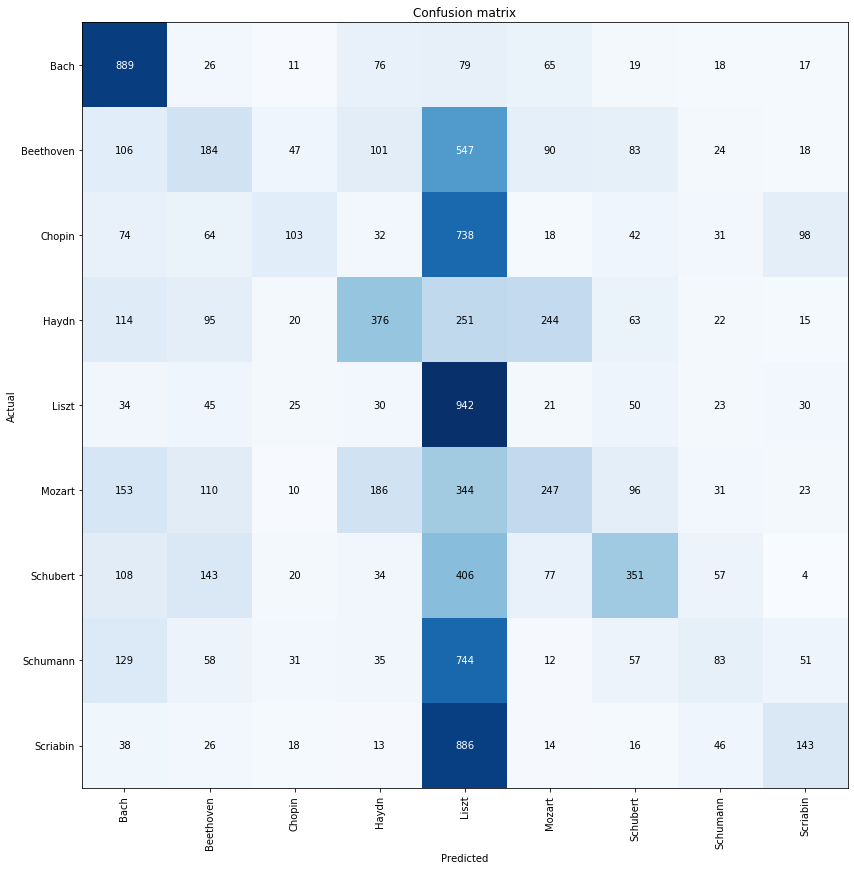

In [25]:
interp.plot_confusion_matrix(figsize=(12,12))